In [75]:
%matplotlib inline

import numpy as np
from tifffile import imread, imsave
from glob import glob
import random
import tqdm
from matplotlib import pyplot as plt
from sklearn.feature_extraction import image
import skimage.io as io


## Preparing data 

In [57]:
#Load the data to use
X = sorted(glob("dataTraining/images/*.tif"))
Y = sorted(glob("dataTraining/gt/*.tiff"))
print('original:', len(X), 'mask:', len(Y))

original: 52 mask: 52


In [58]:
X = list(map(io.imread,X))
Y = list(map(io.imread,Y))

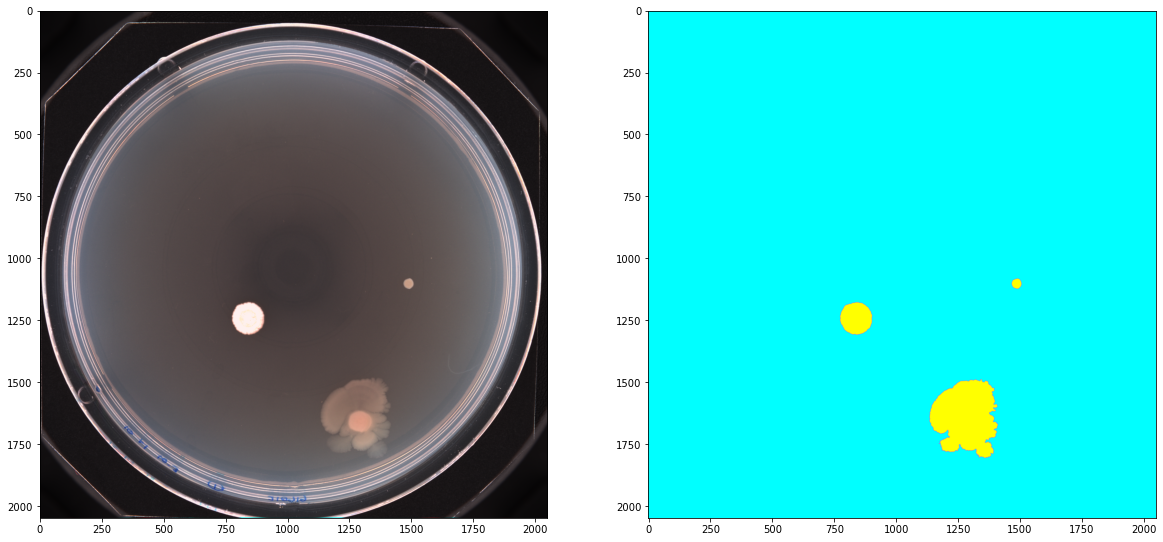

In [62]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.uint8(X[0]/257))
ax[1].imshow(Y[0]);

In [6]:
#Split the data
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
#Pick the percetange to be remove and use as test
n_test = int(round(0.10*len(X)))
ind_pretrn, ind_test = ind[:-n_test], ind[-n_test:]
X_test, Y_test = [X[i] for i in ind_test] , [Y[i] for i in ind_test]
X_pretrn, Y_pretrn = [X[i] for i in ind_pretrn] , [Y[i] for i in ind_pretrn]
print('number of images: %3d' % len(X))
print('- training+validation:       %3d' % len(X_pretrn))
print('- test:     %3d' % len(X_test))

number of images:  52
- training+validation:        47
- test:       5


In [7]:
#Save images to use as tests after training and validation
for i in range(len(X_test)):
    imsave('dataTraining/test/images/' +str(i)+ '.tif', X_test[i])
    imsave('dataTraining/test/gt/'+str(i)+'.tif', Y_test[i])

In [17]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X_pretrn))
n_val = int(round(0.25 * len(X_pretrn)))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X_pretrn[i] for i in ind_val]  , [Y_pretrn[i] for i in ind_val]
X_train, Y_train = [X_pretrn[i] for i in ind_train]  , [Y_pretrn[i] for i in ind_train]
print('number of images: %3d' % len(X_pretrn))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))

number of images:  47
- training:        35
- validation:      12


In [20]:
#Save images to use as training
for i in range(len(X_train)):
    imsave('dataTraining/train/train/images/' +str(i)+ '.tif', X_train[i])
    imsave('dataTraining/train/train/gt/'+str(i)+'.tif', Y_train[i])

In [21]:
#Save images to use validation
for i in range(len(X_val)):
    imsave('dataTraining/train/validation/images/' +str(i)+ '.tif', X_val[i])
    imsave('dataTraining/train/validation/gt/'+str(i)+'.tif', Y_val[i])

In [12]:
np.savez_compressed('dataTraining/train/train_data_n0.npz', 
                    X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val)
np.savez_compressed('dataTraining/test/test_data_n0.npz', 
                    X_test=X_test, Y_test=Y_test)

## Tensorflow

In [76]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.4.1


In [23]:
#Set seed to have fixed random numbers
SEED=42

#Add the paths
dataset_path = "./dataTraining/train/"
training_data = "training/"
val_data = "validation/"

In [64]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Creating our Dataloader

In [155]:
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels), why I need 4 channels?
N_CHANNELS = 4
# Scene Parsing has 2 classes 
N_CLASSES = 4

## Creating a source dataset

In [77]:
import tensorflow_io as tfio

In [156]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "images/" + "*.tif"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "images/" "*.tif"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 35 images.
The Validation Dataset contains 12 images.


In [144]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tfio.experimental.image.decode_tiff(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../train/training/images/*.tif
    # Its corresponding annotation path is:
    # .../train/training/gt/*.tif
    mask_path = tf.strings.regex_replace(img_path, "images", "gt")
    mask_path = tf.strings.regex_replace(mask_path, "tif", "tif")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tfio.experimental.image.decode_tiff(mask)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [157]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "images/" + "*.tif", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "images/" + "*.tif", seed=SEED)
val_dataset =val_dataset.map(parse_image)

## Extra transformations

In [146]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [158]:
BATCH_SIZE = 10

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>


# Visualizing dataset

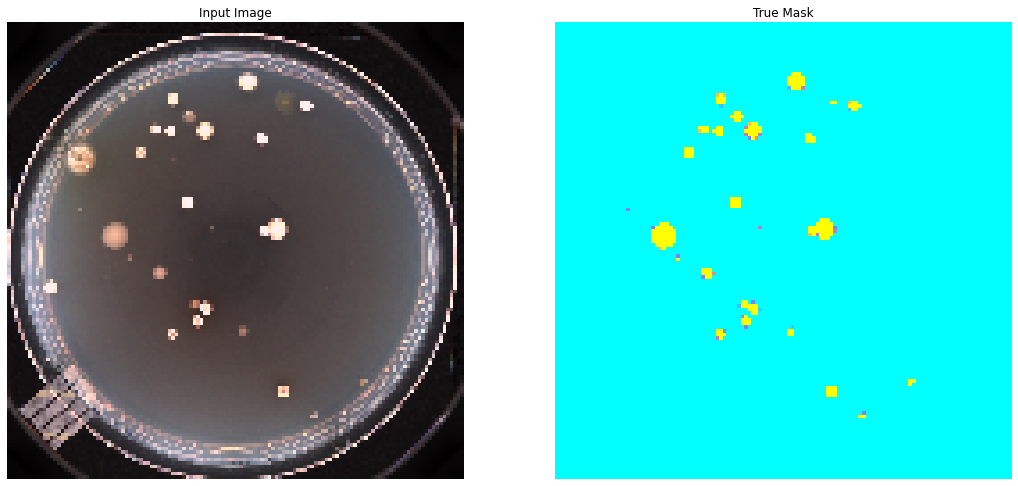

In [159]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

# Implementation

In [149]:
import tensorflow.keras
from tensorflow.keras import Input 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


In [160]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (IMG_SIZE, IMG_SIZE, 4)

# If you want to know more about why we are using `he_normal`:
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excellent fastai course:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

In [161]:
model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Sanity check prediction

In [152]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])
        
        

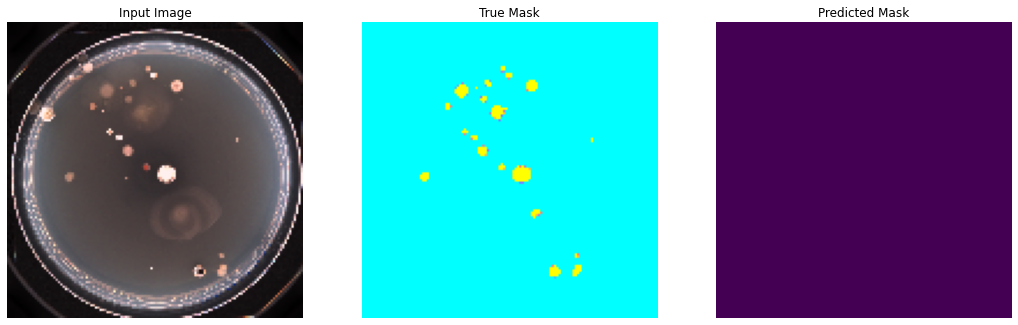

In [162]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

# Train model

## Simple loop

In [125]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

3/3 [==============================] - 29s 8s/step - loss: 1043.7520 - accuracy: 0.1679 - val_loss: 1060.2522 - val_accuracy: 0.9738


## Advance training

In [163]:
EPOCHS = 2

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

Epoch 1/2
3/3 [==============================] - 28s 7s/step - loss: 1690.1569 - accuracy: 3.7028e-04 - val_loss: 9663.9316 - val_accuracy: 3.6621e-04
Epoch 2/2
3/3 [==============================] - 21s 7s/step - loss: 27456.6965 - accuracy: 3.7638e-04 - val_loss: 228300.5469 - val_accuracy: 3.7231e-04


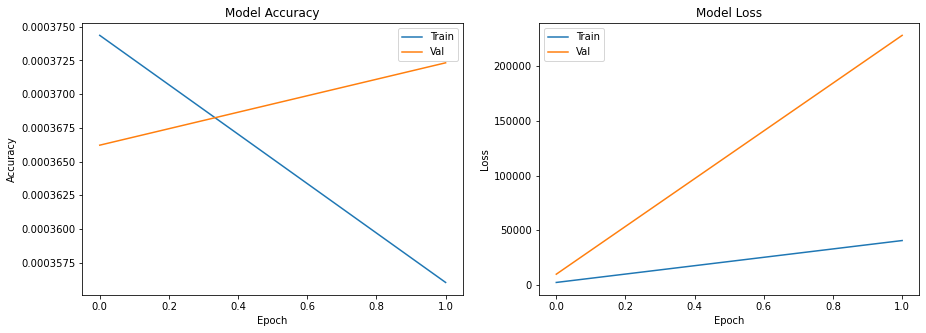

In [164]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(model_history.history['accuracy'])
ax.plot(model_history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(model_history.history['loss'])
ax2.plot(model_history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

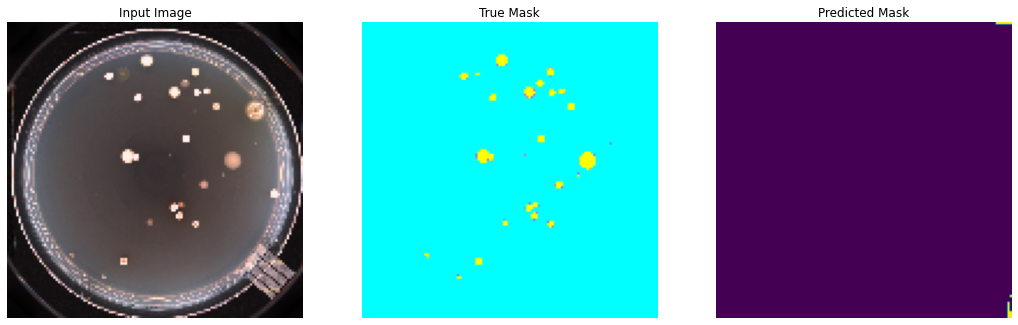

In [132]:
show_predictions()